In [1]:
import os 
import sys
import time

paths_to_add = [
    os.path.abspath(os.path.join('../..')),  
    os.path.abspath(os.path.join('..'))  
]

sys.path.extend(path for path in paths_to_add if path not in sys.path)

In [2]:
import jax
from jax import jit, vmap
import jax.numpy as jnp
import numpy as np
import scipy.stats
from jax import random
import matplotlib.pyplot as plt

from fbpinns import networks
from fbpinns.domains import RectangularDomainND
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import FCN
from fbpinns.schedulers import LineSchedulerRectangularND, AllActiveSchedulerND
from fbpinns.constants import Constants, get_subdomain_ws
from fbpinns.trainers import FBPINNTrainer

from ReactionDiffusionSystem.interactionProblem import InteractionProblemForward3DSoft

In [3]:
# step 1
domain = RectangularDomainND
domain_init_kwargs = dict(
        xmin=np.array([0.,0.,0.]),
        xmax=np.array([2.,1.,1.])
)
# plot 3D 
xmin, xmax = jnp.array([0, 0, 0]), jnp.array([2, 1, 1])
batch_shape = (2, 10,10)
batch_shapes = ((3,3),(4,3),(6,6),(8,8), (9,9), (7,7)) # t_o, t_end, x_left, x_right, y_bottom, y_top

key = jax.random.PRNGKey(0)
sampler = "grid"

ps_ = domain.init_params(xmin, xmax)
all_params = {"static":{"domain":ps_[0]}, "trainable":{"domain":ps_[1]}}
x_batch = domain.sample_interior(all_params, key, sampler, batch_shape)
x_batches = domain.sample_boundaries(all_params, key, sampler, batch_shapes)


# plt.figure()
# plt.scatter(x_batch[:,0], x_batch[:,1])
# for x_batch in x_batches:
#     print(x_batch.shape)
#     plt.scatter(x_batch[:,0], x_batch[:,1])
# plt.show()

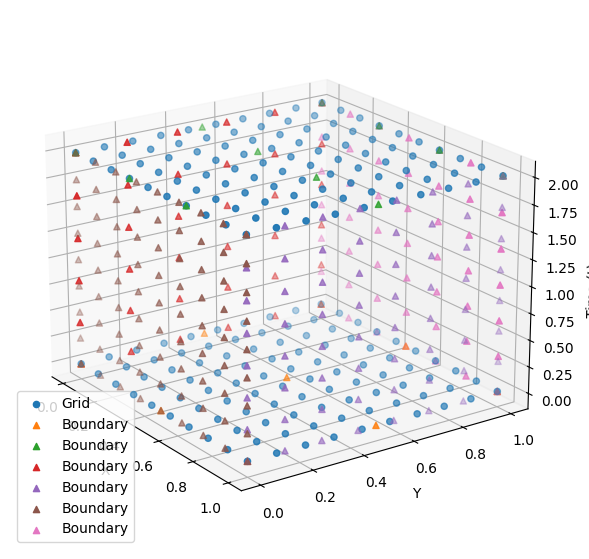

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x_batch[:,1], x_batch[:,2], x_batch[:,0], marker="o", label="Grid")

for x_batch_bc in x_batches:
    ax.scatter(x_batch_bc[:,1], x_batch_bc[:,2], x_batch_bc[:,0], marker='^', label="Boundary")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Time (t)')

ax.view_init(elev=20, azim=-35)
ax.legend()
plt.show()

In [5]:
# step 2: Problem
problem = InteractionProblemForward3DSoft
problem_init_kwargs = dict(
    u_min=0.05, kappa = 0.01, gamma=0.4,
    alpha=0.6, delta=1, eta=0.2, beta=3,
    u0=1, v0=0, time_limit=[0,2], sd=0.1,
    lambda_phy=1e0, lambda_neumann=1e4,
    lambda_ic = 1e4, t_begin=0, t_end=2,
    nbc_points_left=(10,10),  nbc_points_right=(10,10),
    nbc_points_top=(10,10),  nbc_points_bottom=(10,10),
    grid=(15,15,15)
)
problem_init_kwargs

{'u_min': 0.05,
 'kappa': 0.01,
 'gamma': 0.4,
 'alpha': 0.6,
 'delta': 1,
 'eta': 0.2,
 'beta': 3,
 'u0': 1,
 'v0': 0,
 'time_limit': [0, 2],
 'sd': 0.1,
 'lambda_phy': 1.0,
 'lambda_neumann': 10000.0,
 'lambda_ic': 10000.0,
 't_begin': 0,
 't_end': 2,
 'nbc_points_left': (10, 10),
 'nbc_points_right': (10, 10),
 'nbc_points_top': (10, 10),
 'nbc_points_bottom': (10, 10),
 'grid': (15, 15, 15)}

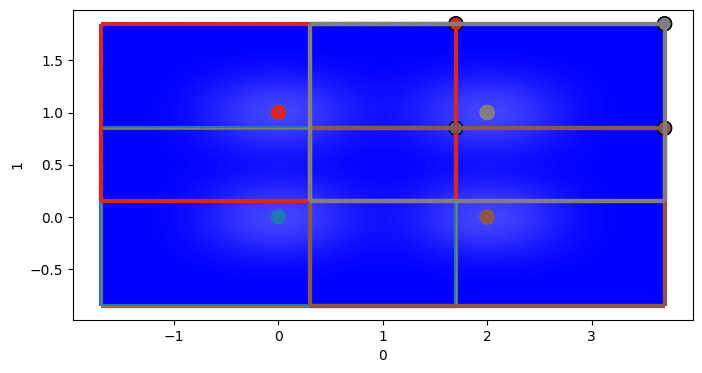

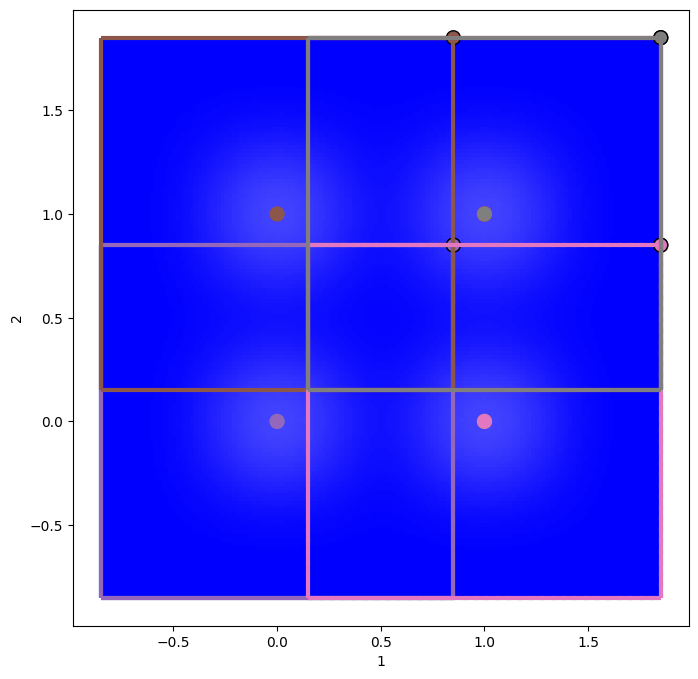

In [6]:
# step 3: Decompostion
decomposition = RectangularDecompositionND
wo = 1.7
subdomain_xs = [np.linspace(0,2,2), np.linspace(0,1,2), np.linspace(0,1,2)]
subdomain_ws = get_subdomain_ws(subdomain_xs, wo)
decomposition_init_kwargs = dict(
    subdomain_xs=subdomain_xs,
    subdomain_ws=get_subdomain_ws(subdomain_xs, wo),
    unnorm=(0.,1.),
)
decomposition_init_kwargs


ps_ = decomposition.init_params(subdomain_xs, subdomain_ws, (0,1))
all_params = {"static":{"decomposition":ps_[0]}, "trainable":{"decomposition":ps_[1]}}
m = all_params["static"]["decomposition"]["m"]
active = np.ones(m)

active[1] = 0
active[2] = 2
decomposition.plot(all_params, iaxes=[0,1], active=active, show_norm=True, show_window=True)
plt.show()
decomposition.plot(all_params, iaxes=[1,2], active=active, show_norm=True, show_window=True)
plt.show()

# ps_ = decomposition.init_params(subdomain_xs, subdomain_ws, (0,1))
# all_params = {"static":{"decomposition":ps_[0]}, "trainable":{"decomposition":ps_[1]}}

# decomposition.plot(all_params)
# plt.show()


In [7]:
# step 4: network
network=FCN
network_init_kwargs = dict(
    layer_sizes = (3, 40, 40, 40, 2),
)

In [8]:
# step 5: Scheduler. Should start from t=0, axis=0
scheduler = LineSchedulerRectangularND
scheduler_kwargs = dict(
        point=[0., 0.], iaxis=0,
    )

In [9]:
tag = "3D"
nc = (15,15,15)
epochs = 10000
h = len(network_init_kwargs["layer_sizes"]) - 2
p = sum(network_init_kwargs["layer_sizes"][1:-1])
run = f"FBPINN_{tag}_{problem.__name__}_{network.__name__}_{nc}-nCol_{epochs}-epochs_{h}-layers_{p}-hidden_{wo}_wo_{LineSchedulerRectangularND.__name__}_fixedWeights_{subdomain_xs[0].shape, subdomain_xs[1].shape, subdomain_xs[2].shape}"
run

'FBPINN_3D_InteractionProblemForward3DSoft_FCN_(15, 15, 15)-nCol_10000-epochs_3-layers_120-hidden_1.7_wo_LineSchedulerRectangularND_fixedWeights_((2,), (2,), (2,))'

In [10]:
# step 6:

from fbpinns.constants import Constants

c = Constants(
    run=run,
    domain=domain,
    domain_init_kwargs=domain_init_kwargs,
    problem=problem,
    problem_init_kwargs=problem_init_kwargs,
    decomposition=decomposition,
    decomposition_init_kwargs=decomposition_init_kwargs,
    network=network,
    network_init_kwargs=network_init_kwargs,
    scheduler=scheduler,
    scheduler_kwargs=scheduler_kwargs,
    ns=(nc,),# use 200 collocation points for training
    n_test=(5,5,5),# use 500 points for testing
    n_steps=epochs,# number of training steps
    clear_output=True,
    show_figures=False,
    test_freq=150000,
    model_save_freq=5000,
    skip_plot_at_first=True,
    sampler='grid',
)
print(c)

run: FBPINN_3D_InteractionProblemForward3DSoft_FCN_(15, 15, 15)-nCol_10000-epochs_3-layers_120-hidden_1.7_wo_LineSchedulerRectangularND_fixedWeights_((2,), (2,), (2,))
domain: <class 'fbpinns.domains.RectangularDomainND'>
domain_init_kwargs: {'xmin': array([0., 0., 0.]), 'xmax': array([2., 1., 1.])}
problem: <class 'ReactionDiffusionSystem.interactionProblem.InteractionProblemForward3DSoft'>
problem_init_kwargs: {'u_min': 0.05, 'kappa': 0.01, 'gamma': 0.4, 'alpha': 0.6, 'delta': 1, 'eta': 0.2, 'beta': 3, 'u0': 1, 'v0': 0, 'time_limit': [0, 2], 'sd': 0.1, 'lambda_phy': 1.0, 'lambda_neumann': 10000.0, 'lambda_ic': 10000.0, 't_begin': 0, 't_end': 2, 'nbc_points_left': (10, 10), 'nbc_points_right': (10, 10), 'nbc_points_top': (10, 10), 'nbc_points_bottom': (10, 10), 'grid': (15, 15, 15)}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [array([0., 2.]), array([0., 1.]), array([0., 1.])], 'subdomain_ws': [array([3.4, 3.4]

In [11]:
c.problem.init_params()

({'dims': (2, 3),
  'u_min': 0.05,
  'kappa': 0.01,
  'gamma': 0.4,
  'alpha': 0.6,
  'delta': 1,
  'eta': 0.2,
  'beta': 3,
  'time_limit': [0, 2],
  'sd': 0.1,
  'u0': 1,
  'v0': 0,
  'lambda_phy': 1.0,
  'lambda_neumann': 10000.0,
  'lambda_ic': 10000.0,
  't_begin': 0,
  't_end': 2,
  'ic_points': (10, 10),
  'nbc_points_left': (5, 5),
  'nbc_points_right': (5, 5),
  'nbc_points_top': (5, 5),
  'nbc_points_bottom': (5, 5),
  'time_keys': Array([0.        , 0.22222222, 0.44444445, 0.6666667 , 0.8888889 ,
         1.1111112 , 1.3333334 , 1.5555556 , 1.7777778 , 2.        ],      dtype=float32),
  'U0': Array([100], dtype=int32),
  'grid': (10, 10, 10)},
 {'usums_rest': Array([200., 200., 200., 200., 200., 200., 200., 200., 200.], dtype=float32)})

In [12]:
# step 7:
training_time = time.time()
FBPINNrun = FBPINNTrainer(c)
FBPINNrun.train()

training_time = time.time() - training_time
print(training_time)

[INFO] 2024-03-28 14:03:59 - <fbpinns.constants.Constants object at 0x0000012DE1D94D90>
run: FBPINN_3D_InteractionProblemForward3DSoft_FCN_(15, 15, 15)-nCol_10000-epochs_3-layers_120-hidden_1.7_wo_LineSchedulerRectangularND_fixedWeights_((2,), (2,), (2,))
domain: <class 'fbpinns.domains.RectangularDomainND'>
domain_init_kwargs: {'xmin': array([0., 0., 0.]), 'xmax': array([2., 1., 1.])}
problem: <class 'ReactionDiffusionSystem.interactionProblem.InteractionProblemForward3DSoft'>
problem_init_kwargs: {'u_min': 0.05, 'kappa': 0.01, 'gamma': 0.4, 'alpha': 0.6, 'delta': 1, 'eta': 0.2, 'beta': 3, 'u0': 1, 'v0': 0, 'time_limit': [0, 2], 'sd': 0.1, 'lambda_phy': 1.0, 'lambda_neumann': 10000.0, 'lambda_ic': 10000.0, 't_begin': 0, 't_end': 2, 'nbc_points_left': (10, 10), 'nbc_points_right': (10, 10), 'nbc_points_top': (10, 10), 'nbc_points_bottom': (10, 10), 'grid': (15, 15, 15)}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs'

NaN or Inf found in input tensor.


[INFO] 2024-03-28 14:25:11 - [i: 2000/10000] loss: nan rate: 1.6 elapsed: 0.35 hr FBPINN_3D_InteractionProblemForward3DSoft_FCN_(15, 15, 15)-nCol_10000-epochs_3-layers_120-hidden_1.7_wo_LineSchedulerRectangularND_fixedWeights_((2,), (2,), (2,))


NaN or Inf found in input tensor.


[INFO] 2024-03-28 14:29:01 - [i: 2358/10000] Updating active inputs..
[INFO] 2024-03-28 14:29:01 - [i: 2358/10000] Average number of points/dimension in active subdomains: 15.41
[INFO] 2024-03-28 14:29:04 - [i: 2358/10000] Updating active inputs done (2.57 s)
[INFO] 2024-03-28 14:29:04 - [i: 2358/10000] Compiling update step..
[INFO] 2024-03-28 14:29:04 - x_batch
[INFO] 2024-03-28 14:29:04 - (3240, 3), float32, JVPTracer
[INFO] 2024-03-28 14:29:04 - x_take
[INFO] 2024-03-28 14:29:04 - (13608, 3), float32, JVPTracer
[INFO] 2024-03-28 14:29:04 - x_batch
[INFO] 2024-03-28 14:29:04 - (3240, 3), float32, JVPTracer
[INFO] 2024-03-28 14:29:04 - x_take
[INFO] 2024-03-28 14:29:04 - (13608, 3), float32, JVPTracer
[INFO] 2024-03-28 14:29:04 - x_batch
[INFO] 2024-03-28 14:29:04 - (3240, 3), float32, JVPTracer
[INFO] 2024-03-28 14:29:04 - x_take
[INFO] 2024-03-28 14:29:04 - (13608, 3), float32, JVPTracer
[INFO] 2024-03-28 14:29:04 - x_batch
[INFO] 2024-03-28 14:29:04 - (216, 3), float32, DynamicJax

NaN or Inf found in input tensor.


[INFO] 2024-03-28 16:01:54 - [i: 9000/10000] loss: nan rate: 1.6 elapsed: 1.96 hr FBPINN_3D_InteractionProblemForward3DSoft_FCN_(15, 15, 15)-nCol_10000-epochs_3-layers_120-hidden_1.7_wo_LineSchedulerRectangularND_fixedWeights_((2,), (2,), (2,))


NaN or Inf found in input tensor.


[INFO] 2024-03-28 16:12:12 - [i: 10000/10000] loss: nan rate: 1.6 elapsed: 2.14 hr FBPINN_3D_InteractionProblemForward3DSoft_FCN_(15, 15, 15)-nCol_10000-epochs_3-layers_120-hidden_1.7_wo_LineSchedulerRectangularND_fixedWeights_((2,), (2,), (2,))


NaN or Inf found in input tensor.


[INFO] 2024-03-28 16:12:12 - [i: 10000/10000] Training complete
7692.634503364563


Import model and see

In [13]:
from FBPINNsModel.plot import load_FBPINN, load_PINN, exact_solution
from fbpinns.analysis import load_model

c, model = load_model(run, rootdir="results/")

# Test model
from fbpinns.analysis import FBPINN_solution, PINN_solution
i, all_params, all_opt_states, active, u_test_losses = model
x_batch_test = domain.sample_interior(all_params=all_params, key=None, sampler="grid", batch_shape=(20, 20, 20))
out = FBPINN_solution(c, all_params, active, x_batch_test)

u_test, v_test= out[:,0:1],out[:,1:2]

[INFO] 2024-03-28 17:57:46 - Loading model from:
results/models/FBPINN_3D_InteractionProblemForward3DSoft_FCN_(15, 15, 15)-nCol_10000-epochs_3-layers_120-hidden_1.7_wo_LineSchedulerRectangularND_fixedWeights_((2,), (2,), (2,))/model_00010000.jax
[INFO] 2024-03-28 17:57:47 - x_batch
[INFO] 2024-03-28 17:57:47 - (8000, 3), float32, ArrayImpl
[INFO] 2024-03-28 17:57:47 - x_take
[INFO] 2024-03-28 17:57:47 - (39304, 3), float32, ArrayImpl


In [14]:
jnp.unique(x_batch_test[:,0])

Array([0.        , 0.10526316, 0.21052632, 0.31578946, 0.42105263,
       0.5263158 , 0.6315789 , 0.7368421 , 0.84210527, 0.94736844,
       1.0526316 , 1.1578947 , 1.2631578 , 1.3684211 , 1.4736842 ,
       1.5789474 , 1.6842105 , 1.7894737 , 1.8947369 , 2.        ],      dtype=float32)

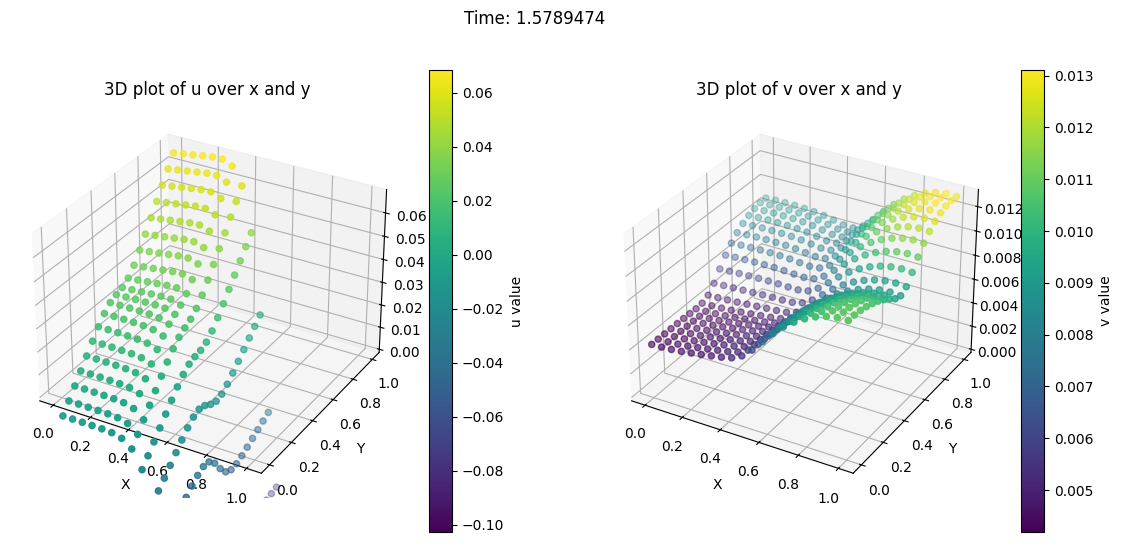

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

time = 1.5789474

indices = x_batch_test[:, 0] == time
x_at_t = x_batch_test[indices, 1]
y_at_t = x_batch_test[indices, 2]
u_at_t = u_test[indices] 
v_at_t = v_test[indices]  

fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(121, projection='3d')
sc1 = ax1.scatter(x_at_t, y_at_t, u_at_t, c=u_at_t, cmap='viridis')
plt.colorbar(sc1, ax=ax1, label='u value')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('u')
ax1.set_title('3D plot of u over x and y')
ax1.set_zlim(0, u_at_t.max())

ax2 = fig.add_subplot(122, projection='3d')
sc2 = ax2.scatter(x_at_t, y_at_t, v_at_t, c=v_at_t, cmap='viridis')
plt.colorbar(sc2, ax=ax2, label='v value')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('v')
ax2.set_title('3D plot of v over x and y')
ax2.set_zlim(0, v_at_t.max())

fig.suptitle(f"Time: {time}")

plt.show()


In [25]:
all_params["trainable"]["problem"]

{'usums': Array([1.2936863e-02, 2.0000000e+02, 2.0000000e+02, 2.0000000e+02,
        2.0000000e+02, 2.0000000e+02, 2.0000000e+02, 2.0000000e+02,
        2.0000000e+02, 2.0000000e+02, 2.0000000e+02, 2.0000000e+02,
        2.0000000e+02, 2.0000000e+02, 2.0000000e+02], dtype=float32)}